In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit,RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score

# Dataset

In [16]:
df=pd.read_csv('df_cleaned.csv')

df

,Unnamed: 0,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,0,37,Female,United States,No_data,No,1,Often,6-25,No,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,1,44,Male,United States,No_data,No,0,Rarely,More than 1000,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,2,32,Male,Canada,No_data,No,0,Rarely,6-25,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,3,31,Male,United Kingdom,No_data,Yes,1,Often,26-100,No,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,4,31,Male,United States,No_data,No,0,Never,100-500,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,1254,26,Male,United Kingdom,No,No,1,No_data,26-100,No,...,Don't know,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No
1200,1255,32,Male,United States,No,Yes,1,Often,26-100,Yes,...,Yes,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No
1201,1256,34,Male,United States,No,Yes,1,Sometimes,More than 1000,No,...,Don't know,Somewhat difficult,Yes,Yes,No,No,No,No,No,No
1202,1257,46,Female,United States,No,No,0,No_data,100-500,Yes,...,Don't know,Don't know,Yes,No,No,No,No,No,No,No


# Feature Engineering

In [17]:

df.drop('Unnamed: 0',axis=1,inplace=True)
df['leave']=df['leave'].map({'Very difficult': 0,'Somewhat difficult': 1,"Don't know": 2,'Somewhat easy': 3,'Very easy': 4})
df['risk_score']= df['family_history'].map({'Yes':1,'No':0})+df['mental_health_consequence'].map({'Yes':2,'No':0,"Don't know":1})+df['mental_vs_physical'].map({'Yes':2,'No':0,"Don't know":1})
df['Support']=df['benefits'].map({'Yes':1,'No':0,"Don't know":0.5})+df['care_options'].map({'Yes':1,'No':0,"Not sure":0.5})+df['wellness_program'].map({'Yes':1,'No':0,"Don't know":0.5})+df['leave']

<Axes: >

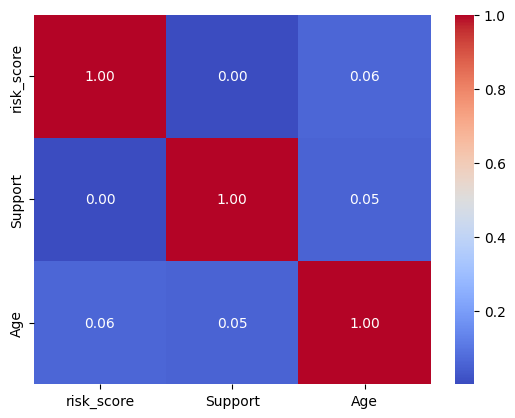

In [18]:
sns.heatmap(df[['risk_score','Support','Age']].corr(),annot=True,cmap='coolwarm',fmt='.2f')

# Random Forest Classifier

### Preprocessing

In [19]:
encode_cols=list(df.select_dtypes(include='object').columns)
pipeline=Pipeline([
    ("preprocess",ColumnTransformer([
        ('encode',OneHotEncoder(handle_unknown='ignore'),encode_cols),
        ('Robust',RobustScaler(),['Age'])
        ]),
    ),
('Train',RandomForestClassifier(n_jobs=-1))
])
pipeline


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Country',
                                                   'self_employed',
                                                   'family_history',
                                                   'work_interfere',
                                                   'no_employees',
                                                   'remote_work',
                                                   'tech_company', 'benefits',
                                                   'care_options',
                                                   'wellness_program',
                                                   'seek_help', 'anonymity',
                                                   'mental_health_consequence',
                                                   'phys_health_consequence',
                                                   'coworkers', 'supervisor',
                                                   'mental_health_interview',
                                                   'phys_health_interview',
                                                   'mental_vs_physical',
                                                   'obs_consequence']),
                                                 ('Robust', RobustScaler(),
                                                  ['Age'])])),
                ('Train', RandomForestClassifier(n_jobs=-1))])

### Model Training

In [20]:
x=df.drop('treatment',axis=1)
y=df['treatment']
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=40)
for train_idx, test_idx in sss.split(x, y):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

param_grid = {
    'Train__n_estimators': randint(200, 500),
    'Train__min_samples_leaf': randint(1, 6),
    'Train__max_depth': randint(3, 7),
    'Train__min_samples_split': randint(2, 10),
    'Train__max_features': ['sqrt', 'log2']
}


joblib.dump(pipeline, 'mental_health_pipeline.pkl')

['mental_health_pipeline.pkl']

### Model Evaluation

{'Train__max_depth': 4, 'Train__max_features': 'sqrt', 'Train__min_samples_leaf': 2, 'Train__min_samples_split': 9, 'Train__n_estimators': 350}
Accuracy 0.8672199170124482
Classification Report               precision    recall  f1-score   support

           0       0.91      0.82      0.86       120
           1       0.83      0.92      0.87       121

    accuracy                           0.87       241
   macro avg       0.87      0.87      0.87       241
weighted avg       0.87      0.87      0.87       241



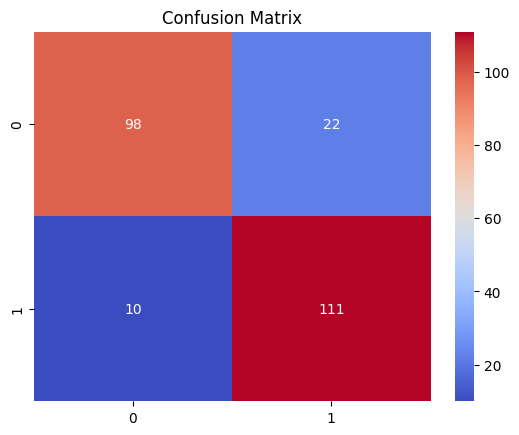

In [21]:
np.random.seed(40)
random_search=RandomizedSearchCV(estimator=pipeline,
                                 param_distributions=param_grid,
                                 cv=5,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 n_iter=100,
                                 random_state=42)
random_search.fit(x_train,y_train)
y_pred=random_search.predict(x_test)
print(random_search.best_params_)
print('Accuracy',accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,cmap='coolwarm',fmt='d')
plt.title("Confusion Matrix")
print("Classification Report",classification_report(y_test,y_pred))

### Important Features

Text(0.5, 1.0, 'Top 10 important Features')

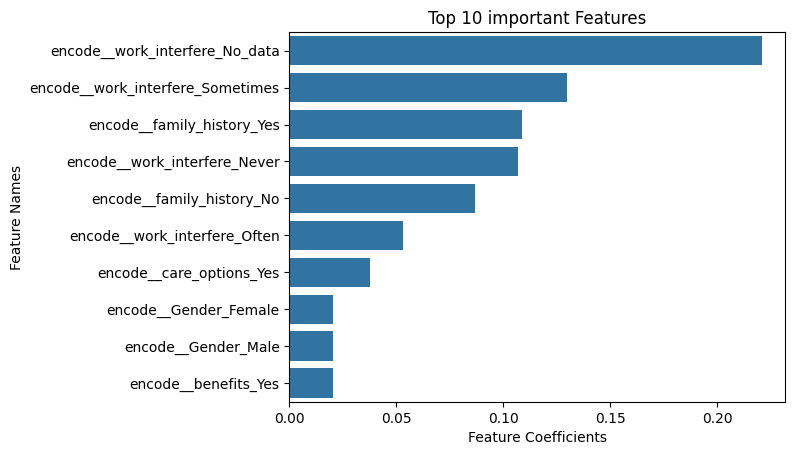

In [22]:
importances=random_search.best_estimator_.named_steps['Train'].feature_importances_
sorted_importance=np.argsort(importances)[::-1]
sorted_importance=sorted_importance[0:10]

feature = random_search.best_estimator_.named_steps['preprocess'].get_feature_names_out()
sns.barplot(y=feature[sorted_importance],x=importances[sorted_importance])
plt.xlabel("Feature Coefficients")
plt.ylabel("Feature Names")
plt.title("Top 10 important Features")

# XGB Classifier

### Preprocessing

In [23]:
encode_cols=list(df.select_dtypes(include='object').columns)
pipeline=Pipeline([
    ("preprocess",ColumnTransformer([
        ('encode',OneHotEncoder(handle_unknown='ignore'),encode_cols),
        ('Robust',RobustScaler(),['Age'])
        ]),
    ),
('Train',XGBClassifier())
])


### Model Training

In [24]:
x=df.drop('treatment',axis=1)
y=df['treatment']
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=40)
for train_idx, test_idx in sss.split(x, y):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

param_grid = {
    'Train__n_estimators': randint(200, 500),
    'Train__subsample': uniform(0.4, 0.6),
    'Train__max_depth': randint(3, 7),
    'Train__max_features': ['sqrt', 'log2']
}

### Model Evaluation

C:\Users\AMRINDER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:28:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "max_features" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Train__max_depth': 5, 'Train__max_features': 'log2', 'Train__n_estimators': 402, 'Train__subsample': np.float64(0.6217926736368427)}
Accuracy 0.8215767634854771
Classification Report               precision    recall  f1-score   support

           0       0.82      0.82      0.82       120
           1       0.82      0.82      0.82       121

    accuracy                           0.82       241
   macro avg       0.82      0.82      0.82       241
weighted avg       0.82      0.82      0.82       241



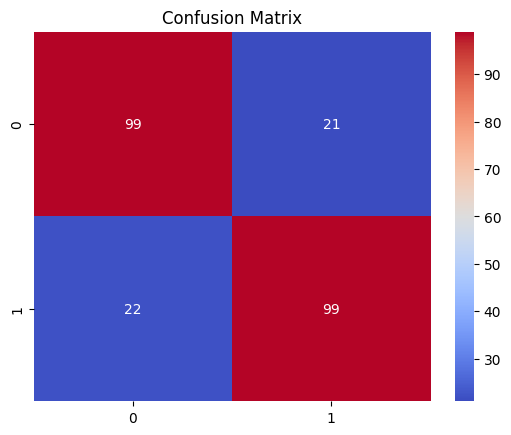

In [25]:
random_search=RandomizedSearchCV(estimator=pipeline,
                                 param_distributions=param_grid,
                                 cv=5,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 n_iter=100,
                                 random_state=42)
random_search.fit(x_train,y_train)
y_pred=random_search.predict(x_test)
print(random_search.best_params_)
print('Accuracy',accuracy_score(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,cmap='coolwarm',fmt='d')
plt.title("Confusion Matrix")
print("Classification Report",classification_report(y_test,y_pred))

### Important Features

Text(0.5, 1.0, 'Top 10 important Features')

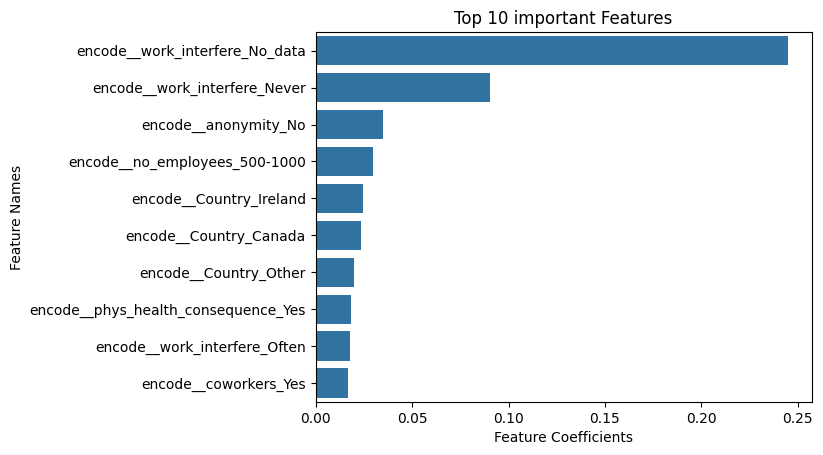

In [26]:
importances=random_search.best_estimator_.named_steps['Train'].feature_importances_
sorted_importance=np.argsort(importances)[::-1]
sorted_importance=sorted_importance[0:10]

feature = random_search.best_estimator_.named_steps['preprocess'].get_feature_names_out()
sns.barplot(y=feature[sorted_importance],x=importances[sorted_importance])
plt.xlabel("Feature Coefficients")
plt.ylabel("Feature Names")
plt.title("Top 10 important Features")